In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import time
import copy
from random import shuffle
#import tqdm.notebook as tqdm
import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2
import os
import shutil
from datetime import datetime 
import sys, os 
from glob import glob 
import imageio

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

In [4]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
Updating files:   2% (28/1174)
Updating files:   3% (36/1174)
Updating files:   4% (47/1174)
Updating files:   4% (51/1174)
Updating files:   5% (59/1174)
Updating files:   6% (71/1174)
Updating files:   7% (83/1174)
Updating files:   8% (94/1174)
Updating files:   9% (106/1174)
Updating files:   9% (111/1174)
Updating files:   9% (115/1174)
Updating files:  10% (118/1174)
Updating files:  11% (130/1174)
Updating files:  12% (141/1174)
Updating files:  13% (153/1174)
Updating files:  14% (165/1174)
Updating files:  14% (170/1174)
Updating files:  14% (174/1174)
Updating files:  15% (177/1174)
Updating files:  16% (188/1174)
error: unable to create file annotations/lungVAE-masks/post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day1_mask.png: Filename too long
error: unable to create file annotations/lungVAE-masks/post-intubuation-pneumomediastium-and-pneumothorax-background-covid-19-pneumonia-day1_mask.png.png: Fi

In [5]:
pwd

'd:\\Thesis\\LAB PC\\Testing Lab PC\\COVID-19-Classification-From-Chest-X-Ray-using-VGG19-Depthwise-CNN-Using-PYTORCH-main'

<h3> EDA </h3>

In [7]:
df = pd.read_csv("covid-chestxray-dataset\metadata.csv")
selected_columns = df[df["finding"] == "Pneumonia/Viral/COVID-19"]
selected_columns = selected_columns[(selected_columns["view"]=="AP") | (selected_columns["view"]=="PA")]
selected_columns.head(2)

,patientid,offset,sex,age,finding,RT_PCR_positive,survival,intubated,intubation_present,went_icu,...,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 29
0,2,0.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3.0,M,65.0,Pneumonia/Viral/COVID-19,Y,Y,N,N,N,...,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


In [8]:
image_datas = selected_columns["filename"].values.tolist()
print(image_datas[:2])

['auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg', 'auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg']


In [14]:
os.makedirs('COVID19-DATASET/Train/Covid19')
os.makedirs('COVID19-DATASET/Train/Normal')

COVID_PATH = 'COVID19-DATASET/Train/Covid19'
NORMAL_PATH = 'COVID19-DATASET/Train/Normal'

In [15]:
for image in image_datas:
    shutil.copy(os.path.join("./covid-chestxray-dataset/images/",image), os.path.join(COVID_PATH, image))

In [16]:
print(len(os.listdir("COVID19-DATASET/Train/Covid19")))

342


In [17]:
for image in os.listdir("chest_xray/train/NORMAL")[:343]:
    shutil.copy(os.path.join("chest_xray/train/NORMAL", image), os.path.join(NORMAL_PATH, image))

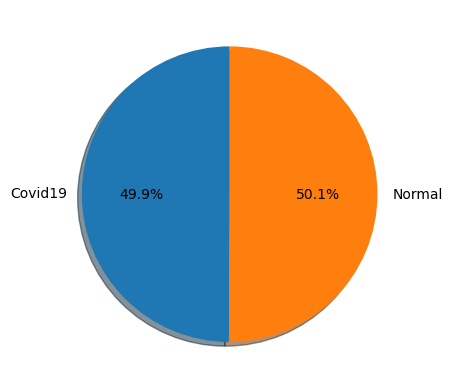

In [18]:
DATA_PATH = 'COVID19-DATASET/Train'
class_names = os.listdir(DATA_PATH)
image_count = {}

for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH, i)))
    
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(), labels=image_count.keys(), shadow=True, 
       autopct = "%1.1f%%", startangle=90)

plt.show()

C:\Users\20301125\AppData\Local\Temp\ipykernel_17456\382330435.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


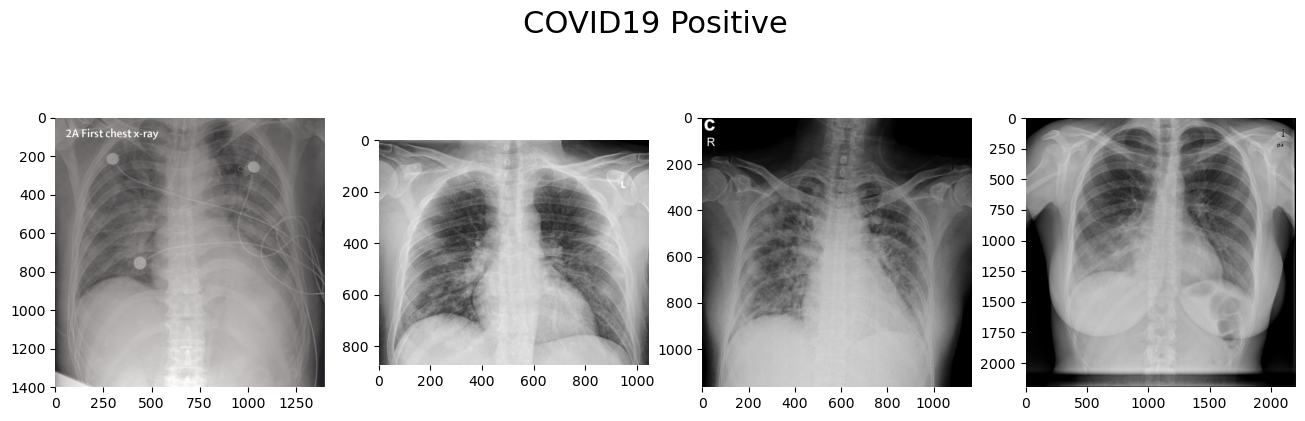

In [19]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)

img_paths = os.listdir(COVID_PATH)
shuffle(img_paths) 

for i, image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image)) 
    plt.subplot(1, 4, i+1, frameon=False)
    plt.imshow(img) 
    
fig.show()


C:\Users\20301125\AppData\Local\Temp\ipykernel_17456\4156702754.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


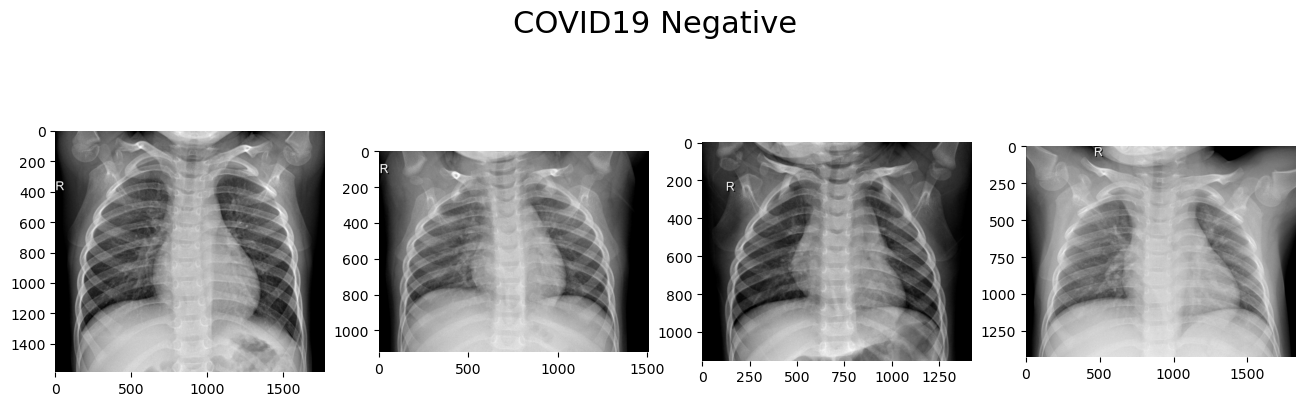

In [20]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative", size=22)

img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths) 

for i, image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image)) 
    plt.subplot(1, 4, i+1, frameon=False)
    plt.imshow(img) 
    
fig.show()

In [21]:
data_transforms = {
    'train_transforms' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(p=0.4),
        transforms.RandomVerticalFlip(),
        transforms.RandomPerspective(distortion_scale=0.0, p=0.0),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

    'test_transforms' : transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

In [22]:
def load_split_train_test(datadir, valid_size=0.2):
    train_data = datasets.ImageFolder(datadir, transform=data_transforms['train_transforms'])
    test_data = datasets.ImageFolder(datadir, transform=data_transforms['test_transforms'])
    
    num_train = len(train_data) 
    indices = list(range(num_train))
    split = int(np.floor(valid_size*num_train))
    np.random.shuffle(indices) 
    
    train_idx, test_idx = indices[split:], indices[:split]
    
    dataset_size = {"train": len(train_idx), "val":len(test_idx)}
    
    train_sampler = SubsetRandomSampler(train_idx)
    
    test_sampler = SubsetRandomSampler(test_idx) 
    
    train_loader = torch.utils.data.DataLoader(train_data,
                                                sampler = train_sampler,
                                                  batch_size=4)
    
    test_loader = torch.utils.data.DataLoader(test_data,
                                                sampler = test_sampler,
                                                  batch_size=4)
    return train_loader, test_loader, dataset_size 
train_loader, val_loader, dataset_size = load_split_train_test(DATA_PATH)
dataloaders = {"train": train_loader, "val":val_loader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train', 'val']}
class_names = train_loader.dataset.classes 
print(class_names)

['Covid19', 'Normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 224, 224])


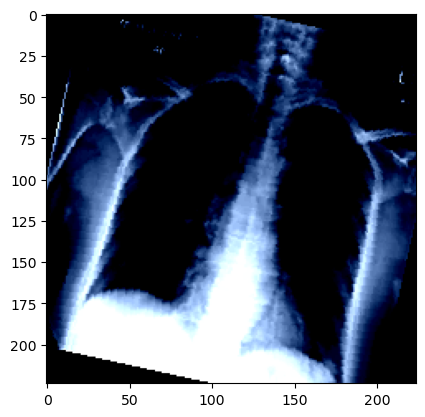

In [23]:
trainBatch = next(iter(train_loader))
image, label = trainBatch 
print(image[0].shape)
plt.imshow(image[0].numpy().transpose((1, 2, 0)))

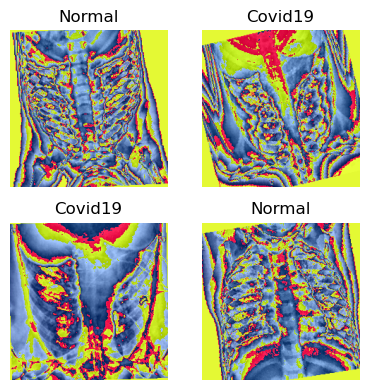

In [24]:
def visualize_batch(batch, classes, dataset_type):

    fig = plt.figure(figsize=(4, 4))

    for i in range(0, 4):
         # create a subplot
        ax = plt.subplot(2, 2, i + 1)

        image = batch[0][i].cpu().numpy()
        image = image.transpose((1, 2, 0))
        image = (image * 255.0).astype("uint8")
        # grab the label id and get the label from the classes list
        idx = batch[1][i]
        label = classes[idx]

        plt.imshow(image)
        plt.title(label)
        plt.axis("off")

    plt.tight_layout()
    plt.show()
    
trainBatch = next(iter(train_loader))
class_names = train_loader.dataset.classes 
visualize_batch(trainBatch, class_names, "train")

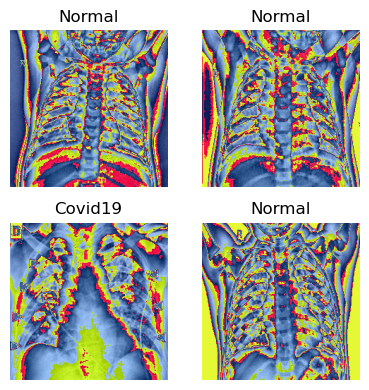

In [25]:
trainBatch = next(iter(val_loader))
class_names = train_loader.dataset.classes 
visualize_batch(trainBatch, class_names, "test")

<h2> Model </h2>

<img src="https://blog.techcraft.org/wp-content/uploads/2021/03/vgg19-architecture2.png"></img>

<h3> DepthWise Convolutional Neural Network </h3>

In [26]:
class DepthwiseConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False):
        super(DepthwiseConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, stride, padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, 1, 0, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

In [27]:
model1 = DepthwiseConv2d(3, 64, 3)
a = torch.randn(1, 3, 224, 224)
b = model1(a)
print(b.size())

torch.Size([1, 64, 224, 224])


<h3> VGG 19 Network Architecture using Depthwise Convolution </h3>

In [28]:

class VGG_19(nn.Module):
    def __init__(self):
        super(VGG_19, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

        self.block2 = nn.Sequential(
        
            DepthwiseConv2d(64, 64, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(64, 128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        
        )

        self.block3 = nn.Sequential(
            DepthwiseConv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(128, 128, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(128, 256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.block4 = nn.Sequential(
            DepthwiseConv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(256, 256, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(256, 512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )


        self.block5 = nn.Sequential(
            DepthwiseConv2d(512, 512, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(512, 512, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(512, 512, kernel_size=3),
            nn.ReLU(),
            DepthwiseConv2d(512, 512, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        self.pool = torch.nn.AdaptiveAvgPool2d((14,14))

        self.fc1 = nn.Linear(512*14*14, 1024)

        self.relu = nn.ReLU()

        self.fc2 = nn.Linear(1024, 512)
        self.relu2 = nn.ReLU()
        self.dropout = nn.Dropout(0.7)
        self.fc3 = nn.Linear(512, 512)
        self.dropout2 = nn.Dropout(0.5)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(256, 32)
        self.relu4 = nn.ReLU()
        self.out = nn.Linear(512, 2)
    

    def forward(self, X):
        out = self.block1(X)
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        #out = self.block5(out)
        out = self.pool(out)
        out = self.fc1(out.view(out.size(0), -1))
        
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.dropout2(out)
        #out = self.fc3(out)
        #out = self.relu3(out)
        #out = self.dropout3(out)
        #out = self.fc4(out)
        #out = self.relu4(out)
        out = self.out(out)

        return out

model = VGG_19()


In [ ]:
'''
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(3 * 224 * 224, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 2)
)
'''

In [29]:
print(model)

VGG_19(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): DepthwiseConv2d(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ReLU()
    (2): DepthwiseConv2d(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): DepthwiseConv2d(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride

In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device) 
model.to(device) 

cuda:0


VGG_19(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): DepthwiseConv2d(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): ReLU()
    (2): DepthwiseConv2d(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
      (pointwise): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): DepthwiseConv2d(
      (depthwise): Conv2d(128, 128, kernel_size=(3, 3), stride

In [31]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
criterion = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


#learning_rate = 0.001
#optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, alpha=0.99, eps=1e-08, weight_decay=0, momentum=0, centered=False)
#scheduler = ReduceLROnPlateau(optimizer, mode='min',factor=0.2, patience=2,min_lr=0.000001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [32]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
105100770


<h3>Training</h3>

In [33]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):

    train_losses = np.zeros(epochs) 
    test_losses = np.zeros(epochs)

    for i in range(epochs):
        valid_loss = 0
        t0 = datetime.now()
        train_loss = [] 
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs) 

            loss = criterion(outputs, targets) 

            loss.backward() 
            optimizer.step() 

            train_loss.append(loss.item()) 

        train_loss = np.mean(train_loss) 

        test_loss = [] 
        for inputs, targets in test_loader:
            
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs) 

            loss = criterion(outputs, targets) 

            
            
            test_loss.append(loss.item()) 
           
        test_loss = np.mean(test_loss) 
        

        train_losses[i] = train_loss 
        test_losses[i] = test_loss
        #scheduler.step(test_loss)
        dt = datetime.now() - t0 

        print(f"Epochs {i+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")

    return train_losses, test_losses

In [34]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, val_loader, epochs=60)

Epochs 1/60, Train Loss: 0.6455, Test Loss: 1.2791, Duration: 0:00:34.782398
Epochs 2/60, Train Loss: 0.5441, Test Loss: 0.6797, Duration: 0:00:22.660394
Epochs 3/60, Train Loss: 0.3175, Test Loss: 0.2235, Duration: 0:00:22.339164
Epochs 4/60, Train Loss: 0.2302, Test Loss: 0.1997, Duration: 0:00:22.446628
Epochs 5/60, Train Loss: 0.2312, Test Loss: 0.2628, Duration: 0:00:22.403271
Epochs 6/60, Train Loss: 0.2291, Test Loss: 0.1927, Duration: 0:00:22.409112
Epochs 7/60, Train Loss: 0.1704, Test Loss: 0.1300, Duration: 0:00:22.427485
Epochs 8/60, Train Loss: 0.1358, Test Loss: 0.0830, Duration: 0:00:22.357328
Epochs 9/60, Train Loss: 0.1440, Test Loss: 0.1127, Duration: 0:00:22.523692
Epochs 10/60, Train Loss: 0.1088, Test Loss: 0.0380, Duration: 0:00:22.684663
Epochs 11/60, Train Loss: 0.1358, Test Loss: 0.0287, Duration: 0:00:22.441079
Epochs 12/60, Train Loss: 0.1307, Test Loss: 0.0350, Duration: 0:00:22.590273
Epochs 13/60, Train Loss: 0.1389, Test Loss: 0.0736, Duration: 0:00:22.45

<h3> Loss and Accuracy Metrics </h3>

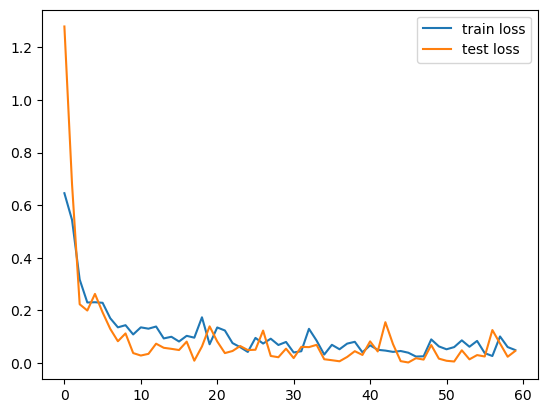

In [35]:
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()
plt.show()

In [36]:
n_correct = 0
n_total = 0 

for images, labels in train_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = model(images) 
  _, predicted = torch.max(outputs, 1)

  n_correct += (predicted==labels).sum().item() 
  n_total += labels.shape[0]

train_acc = n_correct / n_total 
print(f"Training Accuracy: {train_acc}")

Training Accuracy: 0.9854014598540146


In [37]:
n_correct = 0
n_total = 0 

for images, labels in val_loader:
  images, labels = images.to(device), labels.to(device)
  outputs = model(images) 
  _, predicted = torch.max(outputs, 1)

  n_correct += (predicted==labels).sum().item() 
  n_total += labels.shape[0]

train_acc = n_correct / n_total 
print(f"Testing Accuracy: {train_acc}")

Testing Accuracy: 0.9781021897810219


<h3> Inference </h3>

In [38]:
from PIL import Image

tensor([[9.9995e-01, 4.7377e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor(0, device='cuda:0')
COVID


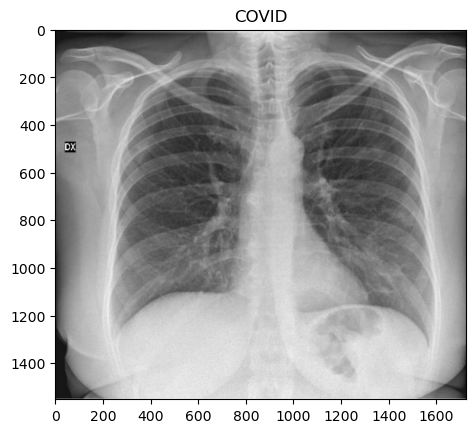

In [39]:

import torch.nn.functional as F
test_transforms1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
a = os.listdir(COVID_PATH)
b = a
from PIL import Image
img = Image.open(COVID_PATH+"/"+a[6]).convert('RGB')
if img.mode!="RGB":
    img = test_transforms1(img).to(device)
    
else:
    img = data_transforms["test_transforms"](img).to(device)
    
a = img.to(device)                   
img = torch.unsqueeze(a, 0)
    
   
model.eval()
prediction = F.softmax(model(img), dim = 1)
print(prediction)
    

prediction = prediction.argmax()
print(prediction)

labels = ['COVID','No Covid']
print(labels[prediction])
plt.imshow(Image.open(COVID_PATH+"/"+b[100]).convert('RGB'))
plt.title(labels[prediction])
plt.show()
    

tensor([[4.1489e-04, 9.9959e-01]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor(1, device='cuda:0')
No Covid
No Covid


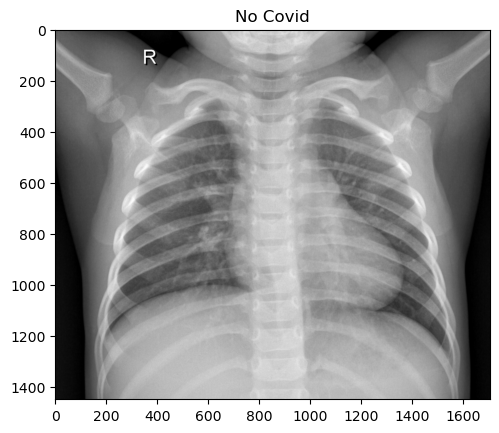

In [40]:

import torch.nn.functional as F
test_transforms1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
a = os.listdir(NORMAL_PATH)
b = a
from PIL import Image
img = Image.open(NORMAL_PATH+"/"+a[6]).convert('RGB')
if img.mode!="RGB":
    img = test_transforms1(img).to(device)
    
else:
    img = data_transforms["test_transforms"](img).to(device)
    
a = img.to(device)                   
img = torch.unsqueeze(a, 0)
    
   
model.eval()
prediction = F.softmax(model(img), dim = 1)
print(prediction)
    

prediction = prediction.argmax()
print(prediction)

labels = ['COVID','No Covid']
print(labels[prediction])
    
    
labels = ['COVID','No Covid']
print(labels[prediction])
plt.imshow(Image.open(NORMAL_PATH+"/"+b[100]).convert('RGB'))
plt.title(labels[prediction])
plt.show()
    
    